In [1]:
%matplotlib inline

# Cholesteric Liquid Crystal Simulation

## Example of a cholesteric liquid crystal
Authors: O. Castany, C. Molinaro, M. Müller

This notebook demonstrates how to model and simulate the optical properties of a cholesteric liquid crystal using pyElli. We will build a helical structure and observe its characteristic selective reflection of circularly polarized light.

In [2]:
import elli
import elli.plot as elliplot
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c, pi

## Setup materials

We start by defining the materials for our model. The liquid crystal will be sandwiched between two layers of isotropic glass with a constant refractive index of 1.55.

The liquid crystal (LC) itself is uniaxial and will be rotated to have the extraordinary axis orientated in x-direction.

In [3]:
glass = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(1.55))
front = back = glass

# Define the ordinary (no) and extraordinary (ne) refractive indices for the LC
(no, ne) = (1.5, 1.7)
Dn = ne - no
n_med = (ne + no) / 2

# Create a uniaxial material with ne oriented along the z-axis by default
LC = elli.UniaxialMaterial(
    elli.ConstantRefractiveIndex(no), elli.ConstantRefractiveIndex(ne)
)

# Rotate the material so the extraordinary axis is along x instead of z
R = elli.rotation_v_theta(elli.E_Y, 90)  # rotation of pi/2 along y
LC.set_rotation(R)  # apply rotation from z to x

## Building the Helical Structure

The defining feature of a cholesteric liquid crystal is its helical structure. The distance over which the director rotates by 360° is known as the cholesteric pitch (p).

We model this by first creating a single TwistedLayer that represents one half-turn of the helix (180° rotation over a distance of p/2). We then stack this layer multiple times using RepeatedLayers to build the full thickness (7.5p) of the liquid crystal cell.

In [4]:
# Cholesteric pitch (nm):
p = 650

# One half turn of a right-handed helix:
TN = elli.TwistedLayer(LC, p / 2, angle=180, div=35)

# Repetition the helix layer
N = 15  # number half pitch repetitions
h = N * p / 2
L = elli.RepeatedLayers([TN], N)
s = elli.Structure(front, [L], back)

## Setting Calculation Parameters

Finally, we define the wavelength range for our simulation around the central wavelength of the reflection band, which is determined by the average refractive index and the pitch.

In [5]:
# Define wavelength range in nm for the calculation
lbda_min, lbda_max = 800, 1200
lbda_B = p * n_med # Expected center of the reflection band
lbda_list = np.linspace(lbda_min, lbda_max, 100)

## Analytical calculation for the maximal reflection

For a cholesteric liquid crystal, we can analytically calculate the approximate edges of the reflection band and the maximum reflectance. This serves as a good check for our full simulation.

In [6]:
# Theoretical maximum reflectance
R_th = np.tanh(Dn / n_med * pi * h / p) ** 2

# Theoretical wavelength edges of the reflection band
lbda_B1, lbda_B2 = p * no, p * ne

## Calculation with pyElli

Now we run the simulation using the s.evaluate() method. This calculates the Jones matrix elements for transmission and reflection.

They are extracted for linear (s and p), as well as circular polarized light (R and L)

In [7]:
# Run the full optical simulation for the defined structure and wavelength list
data = s.evaluate(lbda_list, 0)

# Extract transmission coefficients for linear polarization
T_pp = data.T_pp
T_ps = data.T_ps
T_ss = data.T_ss
T_sp = data.T_sp

# Calculate transmission for unpolarized incident light
T_nn = 0.5 * (T_pp + T_ps + T_sp + T_ss)

# Transmission coefficients for 's' and 'p' polarized light, with
# unpolarized measurement.
T_ns = T_ps + T_ss
T_np = T_pp + T_sp

# Right-circular wave is reflected in the stop-band.
# A right-handed helix reflects right-circular (RR) light.
R_RR = data.Rc_RR
R_LR = data.Rc_LR
T_RR = data.Tc_RR
T_LR = data.Tc_LR

# Left-circular wave is transmitted in the full spectrum.
# T_RL, R_RL, R_LL close to zero, T_LL close to 1.
T_LL = data.Tc_LL
R_LL = data.Rc_LL

## Plotting

Finally, we plot the results. The plot will show the transmission and reflection spectra for various polarizations.

We also draw a shaded rectangle representing the analytically calculated photonic stop-band. Inside this band, we expect to see strong reflection for a specific circular polarization. As our model is a right-handed helix, it should strongly reflect right-circularly polarized light (R_RR).

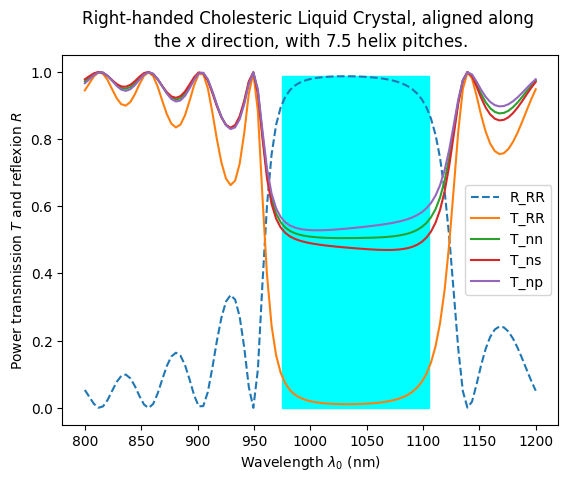

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Draw rectangle for λ ∈ [p·no, p·ne], and T ∈ [0, R_th]
rectangle = plt.Rectangle((lbda_B1, 0), lbda_B2 - lbda_B1, R_th, color="cyan")
ax.add_patch(rectangle)

ax.plot(lbda_list, R_RR, "--", label="R_RR")
ax.plot(lbda_list, T_RR, label="T_RR")
ax.plot(lbda_list, T_nn, label="T_nn")
ax.plot(lbda_list, T_ns, label="T_ns")
ax.plot(lbda_list, T_np, label="T_np")

ax.legend(loc="center right", bbox_to_anchor=(1.00, 0.50))

ax.set_title(
    "Right-handed Cholesteric Liquid Crystal, aligned along \n"
    + "the $x$ direction, with {:.1f} helix pitches.".format(N / 2.0)
)
ax.set_xlabel(r"Wavelength $\lambda_0$ (nm)")
ax.set_ylabel(r"Power transmission $T$ and reflexion $R$")
plt.show()

Additionally we can visualize the refractive index n x direction of the structure in dependance of z position.

<Axes: xlabel='z (nm)', ylabel="n'">

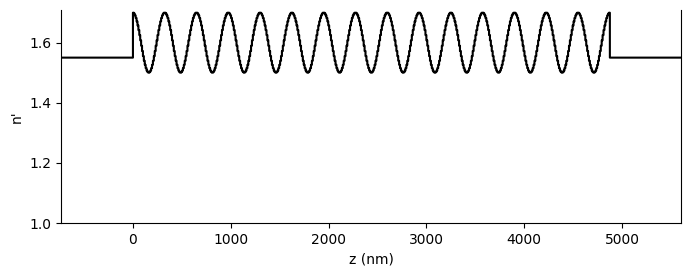

In [9]:
elliplot.draw_structure(s)